In [1]:
# =========================================
# Common Initialization: Imports, Configurations, and Helper Functions
# =========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Global Parameters ----------
CSV_PATH = "Results/param_sweep_results_2.csv"

# Color definitions
COLOR_SWITCH = "#1a80bb"   # HVOR (Switching) blue
COLOR_PURE   = "#ea801c"   # PURE_OR orange
COLOR_SOLID  = "#1a80bb"   # Solid line color
COLOR_DASHED = "#000000"   # Dashed line color

# Line style definitions
DASH_DOT = (0, (6, 2, 1.5, 2))  # dash-dot style
DASHED = (0, (6, 2))            # dashed style
# ----------------------------------------

# Paper-style matplotlib configuration
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "cm",
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

# Common helper function
def paper_axes(ax):
    """Make axes look paper-style: four borders, inward ticks, no grid."""
    ax.set_frame_on(True)
    for side in ("left", "right", "top", "bottom"):
        spine = ax.spines[side]
        spine.set_visible(True)
        spine.set_linewidth(1.0)
        spine.set_edgecolor("black")
        spine.set_position(("outward", 0))
    ax.tick_params(which="both", direction="in", width=1.0, length=4,
                   top=True, right=True)
    ax.grid(False)

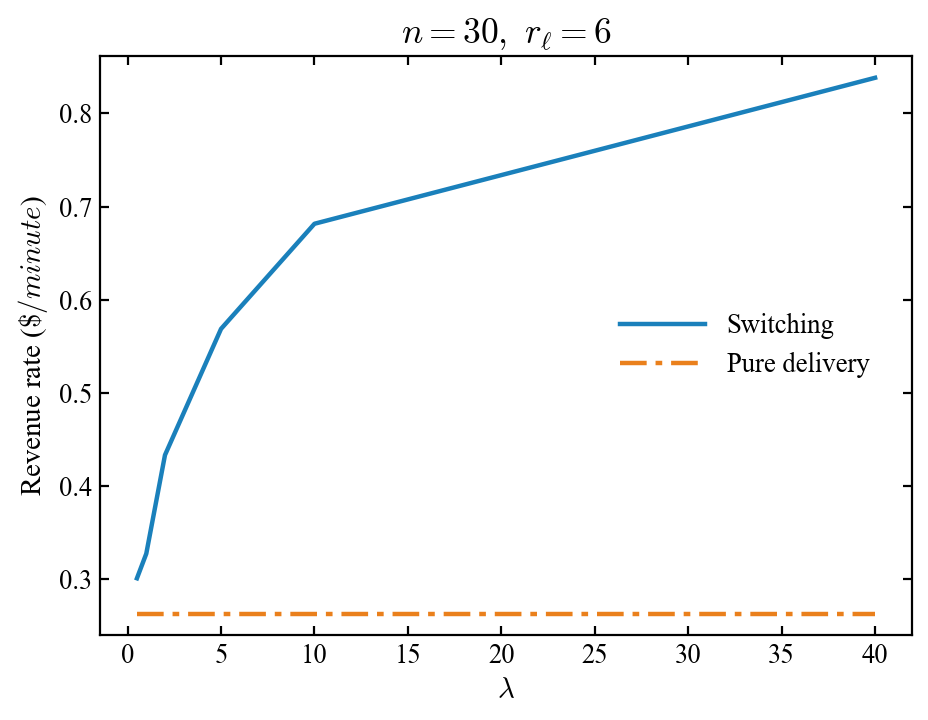

Saved: rev_rate_vs_lambda_n30.png


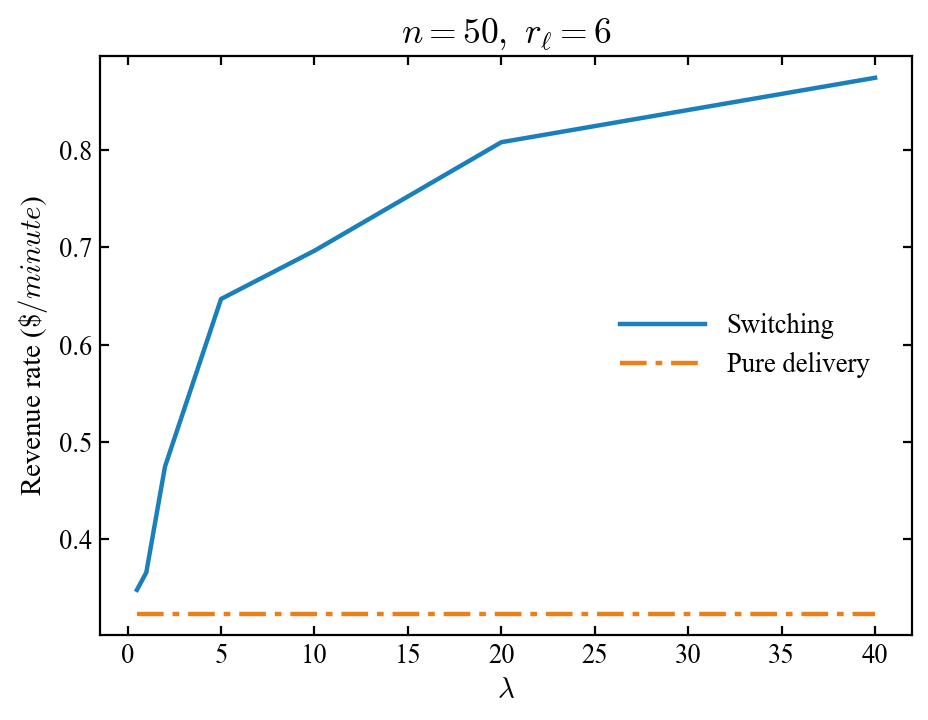

Saved: rev_rate_vs_lambda_n50.png


In [2]:

# =========================================
# Paper-style: Revenue rate vs λ (two separate plots)
# =========================================

def best_alpha_series(df_in: pd.DataFrame, gamma_val, algo_name):
    """For each λ, select R_PICK_ALPHA that gives the highest rate (consistent with paper's optimal α)"""
    sub = df_in[(df_in["GAMMA_PACK"] == gamma_val) & (df_in["algo"] == algo_name)]
    if sub.empty:
        return np.array([]), np.array([])
    grp = (sub.groupby(["LAMBDA", "R_PICK_ALPHA"])["rate"]
              .mean()
              .reset_index())
    best = grp.loc[grp.groupby("LAMBDA")["rate"].idxmax()].sort_values("LAMBDA")
    return best["LAMBDA"].to_numpy(), best["rate"].to_numpy()

# Load and filter data
df = pd.read_csv(CSV_PATH)
df = df[df["RT"] == 6.0].copy()
df = df[df["algo"].isin(["HEUR_VOR", "PURE_OR"])].copy()

# Two separate plots: n=30→γ≈0.50, n=50→γ≈0.83
PANELS = [
    {"title": r"$n=30,\ r_\ell=6$", "gamma": 0.50, "filename": "rev_rate_vs_lambda_n30.png"},
    {"title": r"$n=50,\ r_\ell=6$", "gamma": 0.83, "filename": "rev_rate_vs_lambda_n50.png"},
]

for p in PANELS:
    g = p["gamma"]
    
    # Create single plot
    fig, ax = plt.subplots(1, 1, figsize=(5.9, 4.6), dpi=160)

    # Get data (optimal α for each λ)
    lam_h, rate_h = best_alpha_series(df, g, "HEUR_VOR")
    lam_p, rate_p = best_alpha_series(df, g, "PURE_OR")

    # Plot lines
    if lam_h.size:
        ax.plot(lam_h, rate_h, color=COLOR_SWITCH, lw=2.0, label="Switching")
    if lam_p.size:
        ax.plot(lam_p, rate_p, color=COLOR_PURE, lw=2.0, linestyle=DASH_DOT,
                label="Pure delivery")

    # Axis styling
    paper_axes(ax)
    ax.set_xlabel(r"$\lambda$")
    ax.set_ylabel(r"Revenue rate ($\$/minute$)")
    ax.set_title(p["title"])

    # Legend: inside right, no frame, longer lines
    ax.legend(loc="center right", frameon=False, handlelength=3.2,
              borderaxespad=1.2)

    # Set reasonable y margin to avoid top edge
    y_candidates = []
    if rate_h.size: y_candidates += [rate_h.min(), rate_h.max()]
    if rate_p.size: y_candidates += [rate_p.min(), rate_p.max()]
    if y_candidates:
        ylo, yhi = min(y_candidates), max(y_candidates)
        pad = max(0.01, 0.04 * (yhi - ylo))
        ax.set_ylim(ylo - pad, yhi + pad)

    fig.tight_layout()
    plt.show()
    
    # Save figure
    fig.savefig(p["filename"], dpi=300, bbox_inches="tight")
    print(f"Saved: {p['filename']}")

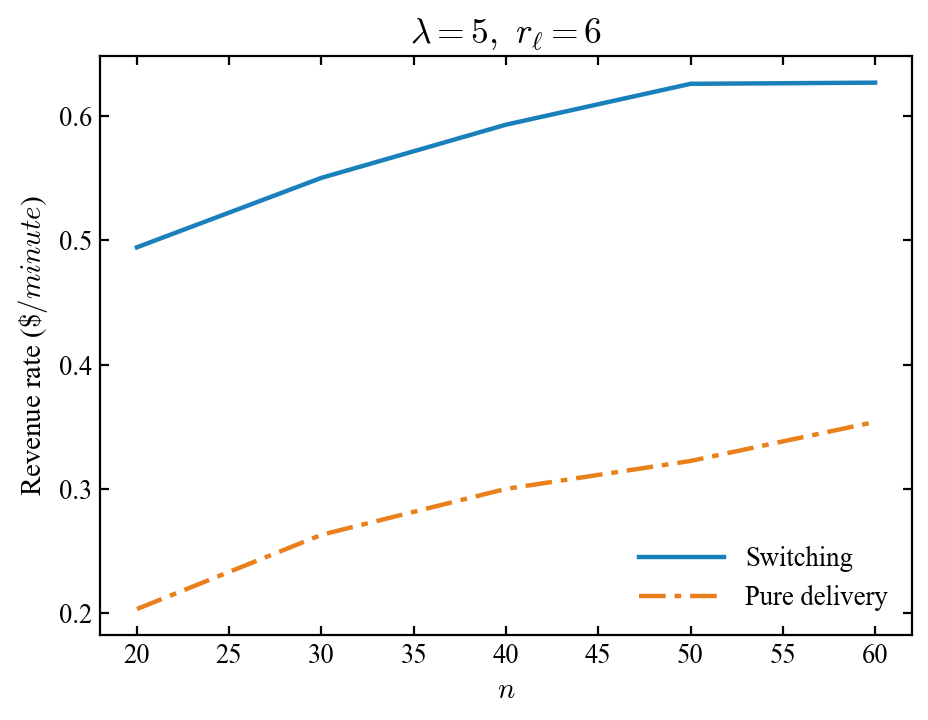

Saved: rev_rate_vs_n_lambda5.png


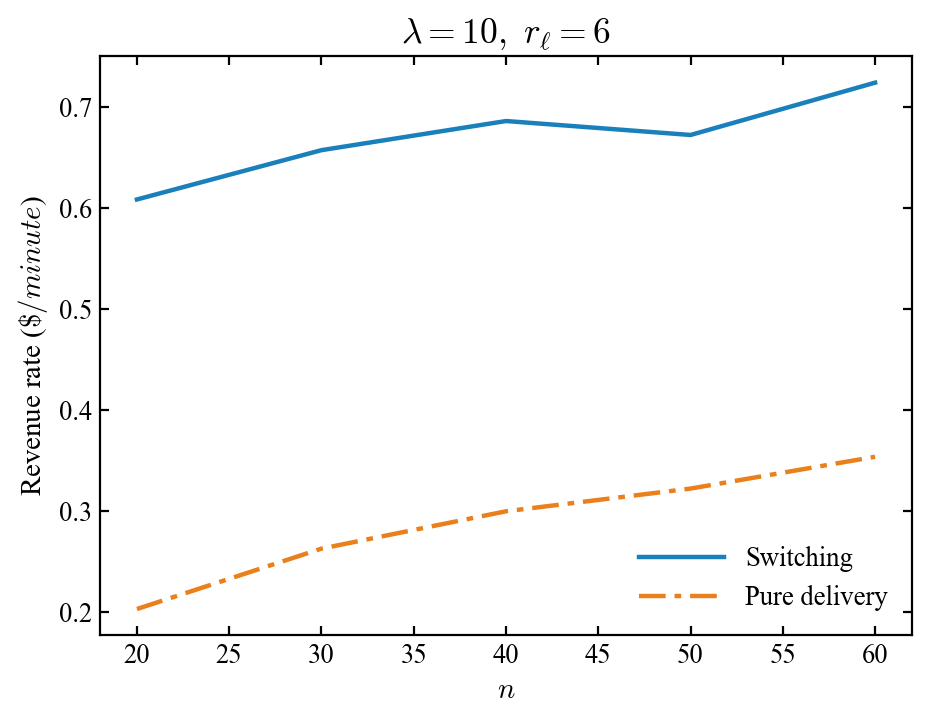

Saved: rev_rate_vs_n_lambda10.png


In [3]:
# =========================================
# Paper-style: Revenue rate vs n (two separate plots for λ)
# =========================================

R_ELL = 6  # r_ℓ for display
LAMBDAS = [5, 10]  # Lambda values for panels

def best_alpha_by_lambda_gamma(df_in: pd.DataFrame, lam, gamma, algo):
    """Fix λ, γ, algo, and select α that gives the maximum average rate"""
    sub = df_in[(df_in["LAMBDA"] == lam) &
                (df_in["GAMMA_PACK"] == gamma) &
                (df_in["algo"] == algo)]
    if sub.empty:
        return np.nan
    # Average over same α first, then take maximum
    alpha_mean = sub.groupby("R_PICK_ALPHA")["rate"].mean()
    return float(alpha_mean.max())

# Load data, keep only the two required curves
df = pd.read_csv(CSV_PATH)
df = df[df["algo"].isin(["HEUR_VOR", "PURE_OR"])].copy()

# γ to n conversion (n ≈ 60*γ)
GAMMAS = [0.33, 0.50, 0.67, 0.83, 1.00]
N_LIST = [int(round(g*60)) for g in GAMMAS]  # -> [20,30,40,50,60]

for lam in LAMBDAS:
    # Create single plot
    fig, ax = plt.subplots(1, 1, figsize=(5.9, 4.6), dpi=160)
    
    # Get optimal α rate for each n (corresponding γ)
    rate_hvor = []
    rate_puro = []
    for g in GAMMAS:
        rate_hvor.append(best_alpha_by_lambda_gamma(df, lam, g, "HEUR_VOR"))
        rate_puro.append(best_alpha_by_lambda_gamma(df, lam, g, "PURE_OR"))

    # Plot lines
    ax.plot(N_LIST, rate_hvor, color=COLOR_SWITCH, lw=2.0, label="Switching")
    ax.plot(N_LIST, rate_puro, color=COLOR_PURE, lw=2.0, linestyle=DASH_DOT, label="Pure delivery")

    # Axis styling and labels
    paper_axes(ax)
    ax.set_xlabel(r"$n$")
    ax.set_ylabel(r"Revenue rate ($\$/minute$)")
    ax.set_title(rf"$\lambda={lam},\ r_\ell={R_ELL}$")

    # Legend: inside lower right, no frame
    ax.legend(loc="lower right", frameon=False, handlelength=3.2)

    # Set appropriate padding
    y_all = [v for v in rate_hvor + rate_puro if np.isfinite(v)]
    if y_all:
        ylo, yhi = min(y_all), max(y_all)
        pad = max(0.01, 0.05*(yhi - ylo if yhi > ylo else 0.2))
        ax.set_ylim(ylo - pad, yhi + pad)

    fig.tight_layout()
    plt.show()
    
    # Save figure
    filename = f"rev_rate_vs_n_lambda{lam}.png"
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Saved: {filename}")

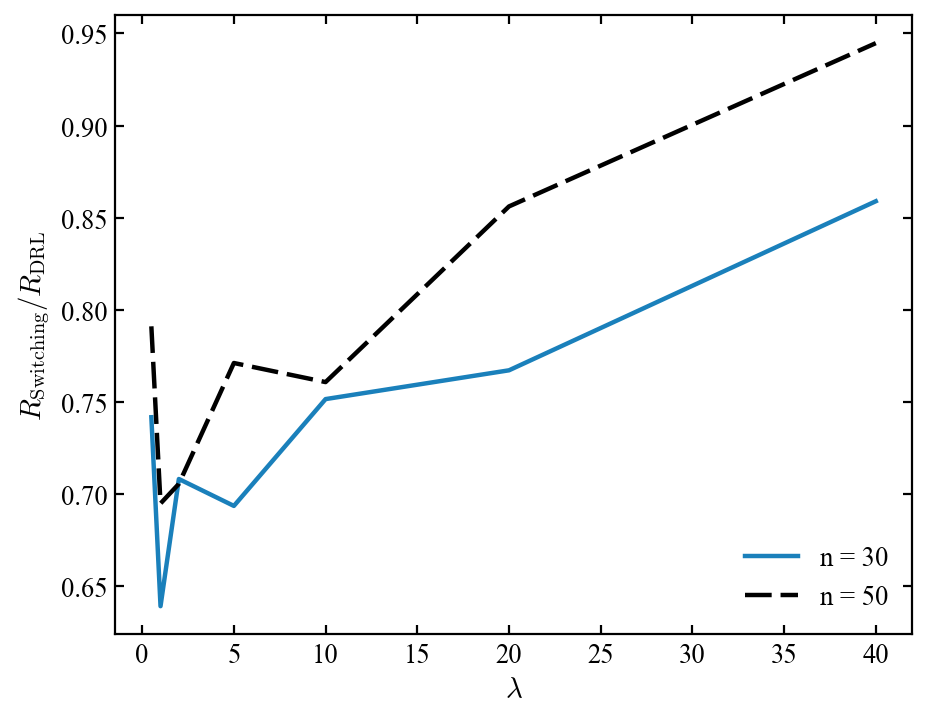

Saved: ratio_hvor_drl_vs_lambda.png


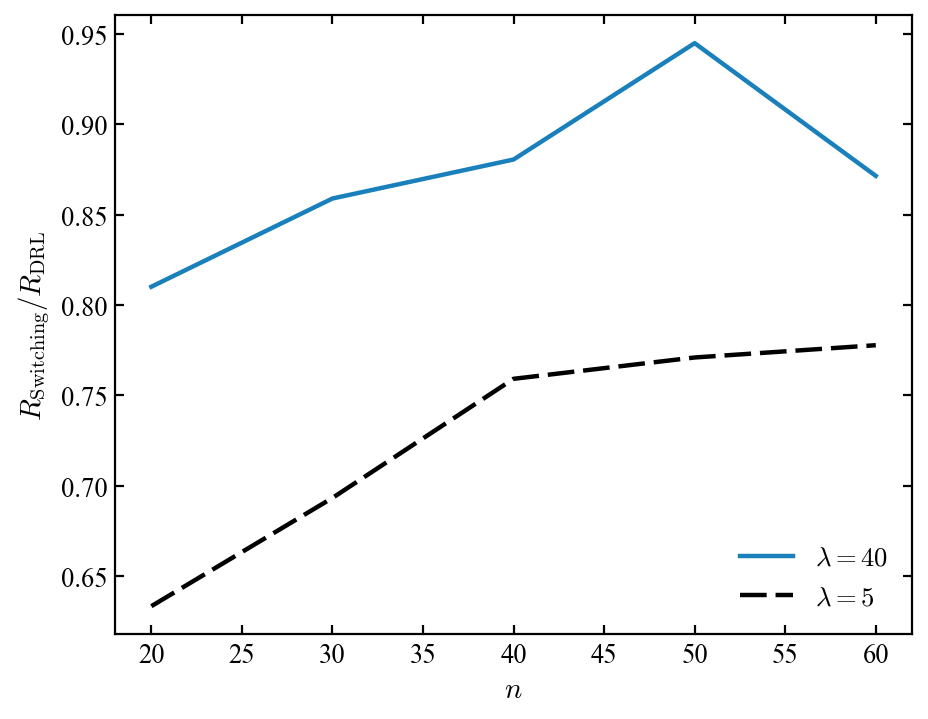

Saved: ratio_hvor_drl_vs_n.png


In [4]:
# =========================================
# Paper-style: Ratio HVOR/DRL vs λ and vs n (two separate plots)
# =========================================

RT_FILTER = 6.0  # Only use results with r_ℓ = 6
LAM_LOW, LAM_HIGH = 5, 40  # Low/high λ for right plot

def best_alpha_rate(df_in, lam, gamma, algo):
    """Fix λ, γ, algo, and select α that maximizes rate (averaged across other parameters)"""
    sub = df_in[(df_in["LAMBDA"] == lam) &
                (df_in["GAMMA_PACK"] == gamma) &
                (df_in["algo"] == algo)]
    if sub.empty:
        return np.nan
    alpha_mean = sub.groupby("R_PICK_ALPHA")["rate"].mean()
    return float(alpha_mean.max())

def drl_avg_rate(df_in, lam, gamma):
    """Fix λ, γ, and average DRL rate (averaged over α and other irrelevant parameters)"""
    sub = df_in[(df_in["LAMBDA"] == lam) &
                (df_in["GAMMA_PACK"] == gamma) &
                (df_in["algo"] == "DRL")]
    if sub.empty:
        return np.nan
    return float(sub["rate"].mean())

# Load and filter by r_ℓ, keep only DRL and HEUR_VOR
df = pd.read_csv(CSV_PATH)
df = df[df["RT"] == RT_FILTER]
df = df[df["algo"].isin(["DRL", "HEUR_VOR"])].copy()

# γ to n conversion (n ≈ 60*γ)
GAMMAS_ALL = sorted(df["GAMMA_PACK"].unique())
N_ALL = [int(round(g*60)) for g in GAMMAS_ALL]
gamma_of_n = {int(round(g*60)): g for g in GAMMAS_ALL}

# ---------- Plot 1: ratio vs λ (two curves: n=30, n=50) ----------
fig, ax = plt.subplots(1, 1, figsize=(5.9, 4.6), dpi=160)

lambda_vals = sorted(df["LAMBDA"].unique())
n_left_curves = [(30, COLOR_SOLID, "solid", "n = 30"),
                 (50, COLOR_DASHED, DASHED, "n = 50")]

for n_val, col, ls, lab in n_left_curves:
    g = gamma_of_n.get(n_val, None)
    if g is None:
        continue
    xs, ys = [], []
    for lam in lambda_vals:
        hv = best_alpha_rate(df, lam, g, "HEUR_VOR")
        dr = drl_avg_rate(df, lam, g)
        if np.isfinite(hv) and np.isfinite(dr) and dr > 0:
            xs.append(lam); ys.append(hv/dr)
    ax.plot(xs, ys, color=col, lw=2.0, linestyle=ls, label=lab)

paper_axes(ax)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$R_{\mathrm{Switching}}/R_{\mathrm{DRL}}$")
ax.legend(loc="lower right", frameon=False)

fig.tight_layout()
plt.show()

# Save figure
filename = "ratio_hvor_drl_vs_lambda.png"
fig.savefig(filename, dpi=300, bbox_inches="tight")
print(f"Saved: {filename}")

# ---------- Plot 2: ratio vs n (two curves: λ=40, λ=5) ----------
fig, ax = plt.subplots(1, 1, figsize=(5.9, 4.6), dpi=160)

lam_right_curves = [(LAM_HIGH, COLOR_SOLID, "solid", rf"$\lambda={LAM_HIGH}$"),
                    (LAM_LOW,  COLOR_DASHED, DASHED, rf"$\lambda={LAM_LOW}$")]

for lam, col, ls, lab in lam_right_curves:
    xs, ys = [], []
    for n_val in sorted(gamma_of_n.keys()):
        g = gamma_of_n[n_val]
        hv = best_alpha_rate(df, lam, g, "HEUR_VOR")
        dr = drl_avg_rate(df, lam, g)
        if np.isfinite(hv) and np.isfinite(dr) and dr > 0:
            xs.append(n_val); ys.append(hv/dr)
    ax.plot(xs, ys, color=col, lw=2.0, linestyle=ls, label=lab)

paper_axes(ax)
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$R_{\mathrm{Switching}}/R_{\mathrm{DRL}}$")
ax.legend(loc="lower right", frameon=False)

fig.tight_layout()
plt.show()

# Save figure
filename = "ratio_hvor_drl_vs_n.png"
fig.savefig(filename, dpi=300, bbox_inches="tight")
print(f"Saved: {filename}")